<h1>Resolving DBSCAN Errors and Testing Meta-Clustering</h1>

In [3]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KDTree
from sklearn.cluster import DBSCAN, KMeans
from functools import partial
from datetime import datetime
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
import os
warnings.filterwarnings('ignore')
test_init()

In [4]:
if os.path.isfile('algo_times.csv'):
    performance = pd.read_csv('algo_times.csv').to_dict('list')
else:
    performance = dict(sample_id=[], task=[], method=[], time_seconds=[])

In [5]:
def timed_apply(sample_go, task_name, gate_name, performance_record, plot=True, save=True):
    start = datetime.now()
    sample_go.apply(gate_name, plot_output=plot)
    end = datetime.now()
    performance['sample_id'].append(sample_go.id)
    performance['method'].append(gate_name)
    performance['time_seconds'].append((end-start).total_seconds())
    performance['task'].append(task_name)
    if save:
        pd.DataFrame(performance).to_csv('algo_times.csv', index=False)
    return performance_record

In [6]:
def visualise_manual_rect(sample_go, parent_population, x, y, x_min, x_max, y_min, y_max, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(parent_population).copy(), [x, y], 'logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    r = Rectangle(xy=(x_min, y_min), width=x_max, height=y_max, fill=False, edgecolor='r')
    ax.add_patch(r)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [7]:
def visualise_manual_ellipse(sample_go, population, x, y, centroid, width, height, angle, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(population)[[x, y]], features_to_transform=[x,y],
                           transform_method='logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, fill=False, edgecolor='r')
    ax.add_patch(ellipse)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [8]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

Remove autonomous gates and populations applied with erronous gates.

In [9]:
samples = exp.list_samples()
samples = [x for x in samples if x!= 'sep6']

In [9]:
populations_to_remove = ['gmm_gdt', 'gmm_gdtNEG', 'dbscan_gdt', 'dbscan_nongdt', 'dbscan_vd2',
                        'hdbscan_gdt', 'hdbscan_nongdt', 'hdbscan_vd2', 'dens2d_gdt', 'dens2d_nongdt',
                        'dens2d_vd2', 'dens2d_noise']
gates_to_remove = ['gmm_gdt', 'dbscan_gdt', 'hdbscan_gdt', 'dens2d_gdt']
for x in samples:
    hc = Gating(exp, x)
    for p in populations_to_remove:
        if p in hc.populations.keys():
            hc.populations.pop(p)
    for g in gates_to_remove:
        if g in hc.gates.keys():
            hc.gates.pop(g)
    hc.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [11]:
hc = Gating(exp, 'hc1')

Expected 3 populations, identified 6; 6


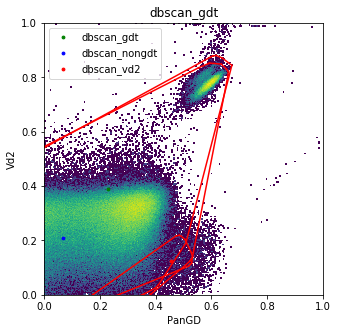

In [11]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

sampling_kwargs = dict()
gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, distance_nn=0.02,
                      downsample_method='density', frac=0.2)
hc.create_gate(gate_name='dbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
               method='dbscan', kwargs=gate_definition, child_populations=child_populations)
hc.apply('dbscan_gdt')

In [12]:
test = apply_transform(hc.get_population_df('manual_liveCD3'), ['PanGD', 'Vd2'], 'logicle')

In [13]:
d = np.ceil(test.shape[0]/30000)
chunksize = int(np.ceil(test.shape[0]/d))

In [14]:
def density_dependent_downsample(data, features: list, sample_n: int, alpha: int = 5,
                                 mmd_sample_n: int = 2000, outlier_dens: float = 1,
                                 target_dens: float = 5):

    def prob_downsample(local_d, target_d, outlier_d):
        if local_d <= outlier_d:
            return 0
        if outlier_d < local_d <= target_d:
            return 1
        if local_d > target_d:
            return target_d / local_d

    df = data.copy()
    mmd_sample = df.sample(mmd_sample_n)
    tree = KDTree(mmd_sample[features], metric='manhattan')
    dist, _ = tree.query(mmd_sample[features], k=2)
    dist = np.median([x[1] for x in dist])
    dist_threshold = dist * alpha
    ld = tree.query_radius(df[features], r=dist_threshold, count_only=True)
    od = np.percentile(ld, q=outlier_dens)
    td = np.percentile(ld, q=target_dens)
    prob_f = partial(prob_downsample, target_d=td, outlier_d=od)
    prob = list(map(lambda x: prob_f(x), ld))
    if sum(prob) == 0:
        print('Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform '
              'samplings')
        return df.sample(sample_n)
    return df.sample(n=sample_n, weights=prob)

In [15]:
def sampling(data, threshold, chunksize):
    if data.shape[0] <= threshold:
        return data
    return density_dependent_downsample(data, sample_n=chunksize, features=['PanGD', 'Vd2'])

In [16]:
chunks = list()
data = test.copy()
start = datetime.now()
while data.shape[0] > 0:
    sample = sampling(data, chunksize, chunksize)
    data = data[~data.index.isin(sample.index)]
    chunks.append(sample)
    end = datetime.now()
    print(f'Elapsed time: {(end-start).total_seconds()}')

Elapsed time: 3.073602
Elapsed time: 6.05998
Elapsed time: 8.871871
Elapsed time: 11.566947
Elapsed time: 14.081167
Elapsed time: 16.40798
Elapsed time: 18.59965
Elapsed time: 20.572116
Elapsed time: 22.384401
Elapsed time: 24.03788
Elapsed time: 25.539083
Elapsed time: 26.876995
Elapsed time: 28.04324
Elapsed time: 29.046561
Elapsed time: 29.906529
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Elapsed time: 30.582007
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Elapsed time: 31.098787
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Elapsed time: 31.4457
Elapsed time: 31.449079


In [17]:
len(chunks)

19

In [18]:
sum([x.shape[0] for x in chunks])

559444

In [19]:
test.shape[0]

559444

In [20]:
[x.shape[0] for x in chunks]

[29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29445,
 29434]

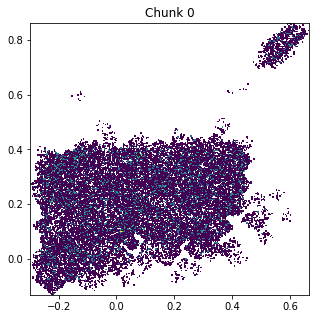

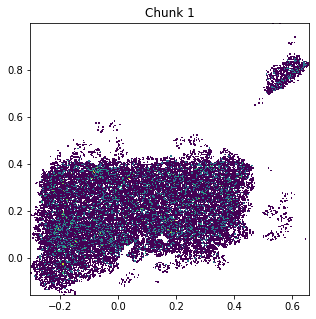

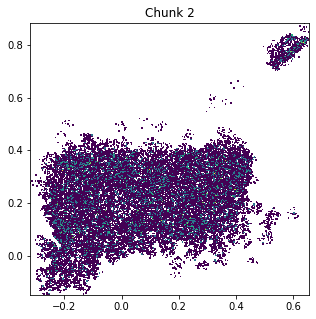

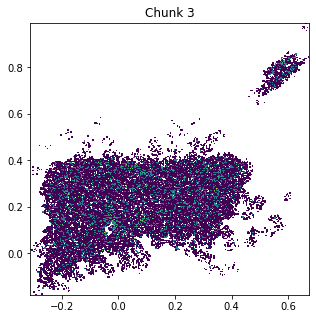

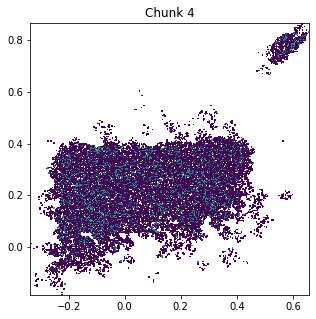

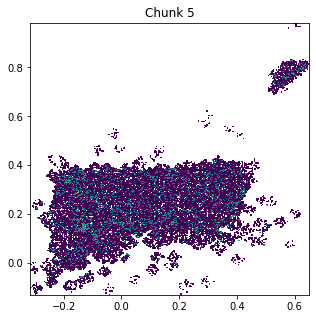

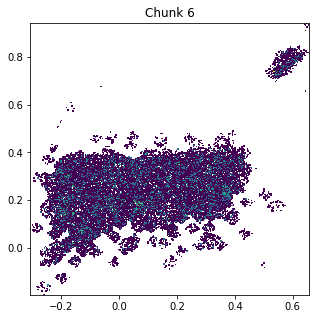

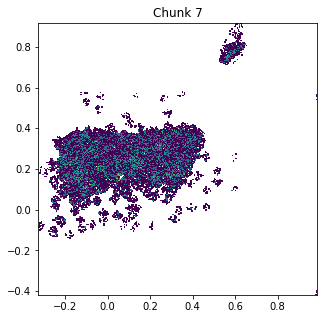

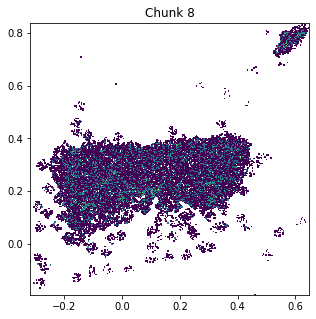

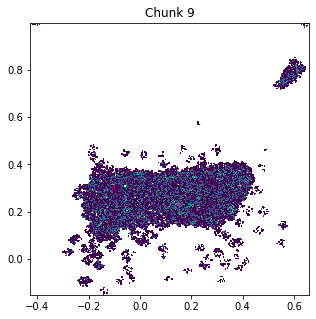

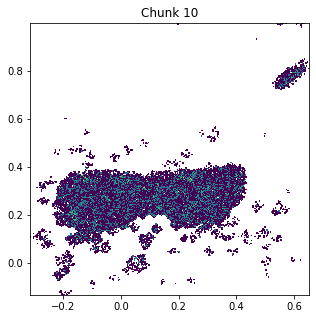

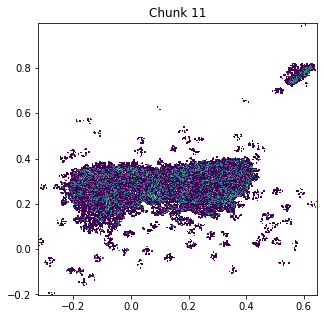

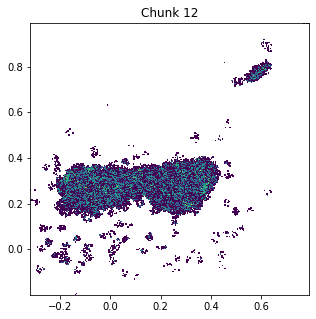

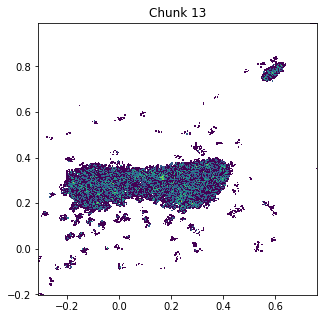

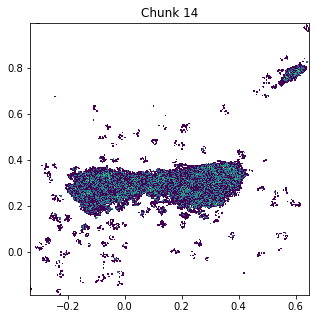

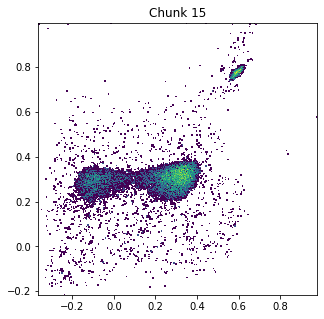

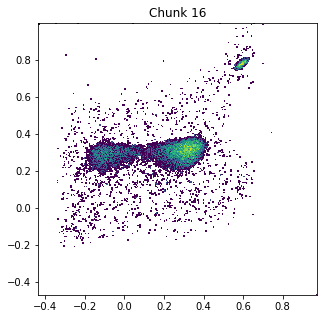

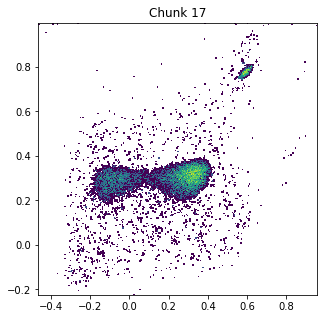

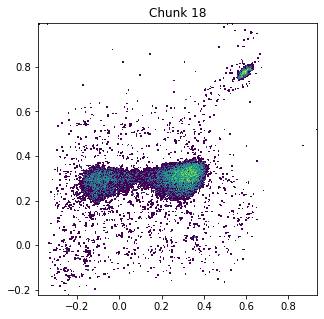

In [21]:
for i, x in enumerate(chunks):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(x['PanGD'], x['Vd2'], bins=500, norm=LogNorm())
    ax.set_title(f'Chunk {i}')
    fig.show()

Clustering 0...
Clustering 1...
Clustering 2...
Clustering 3...
Clustering 4...
Clustering 5...
Clustering 6...
Clustering 7...
Clustering 8...
Clustering 9...
Clustering 10...
Clustering 11...
Clustering 12...
Clustering 13...
Clustering 14...
Clustering 15...
Clustering 16...
Clustering 17...
Clustering 18...


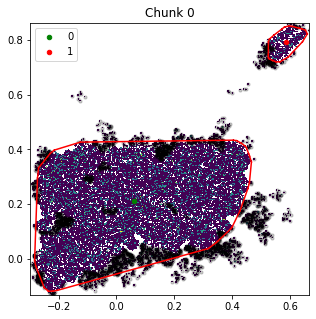

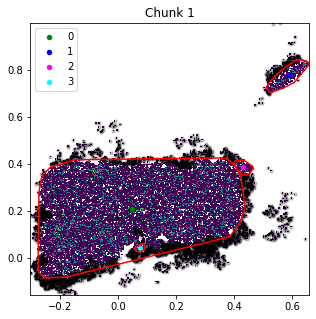

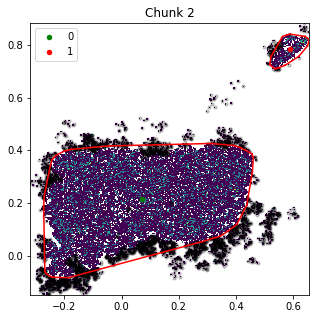

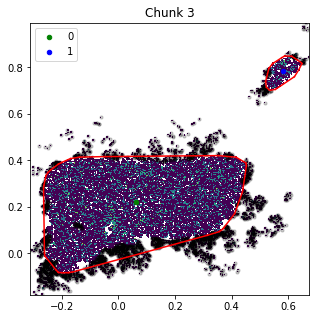

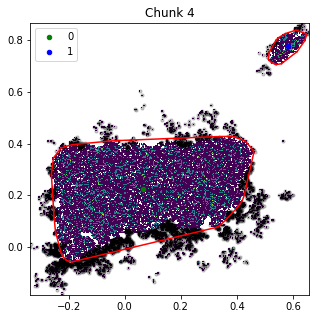

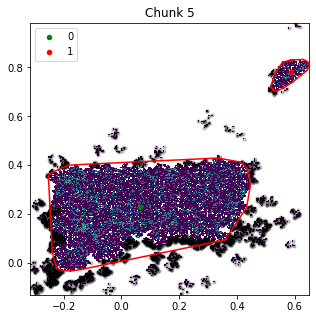

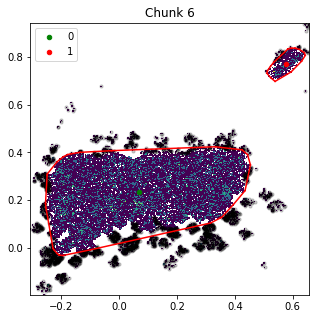

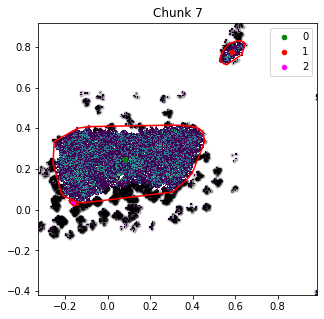

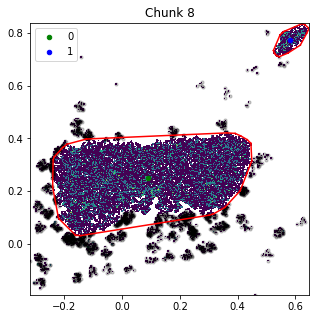

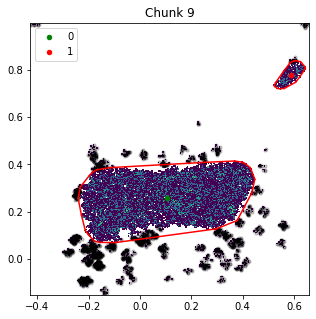

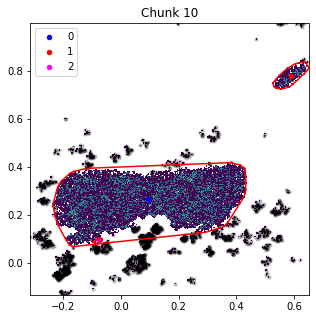

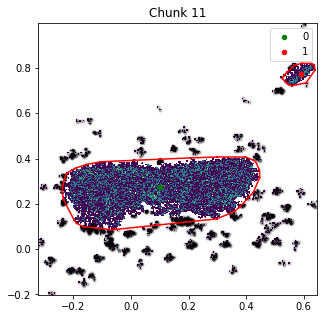

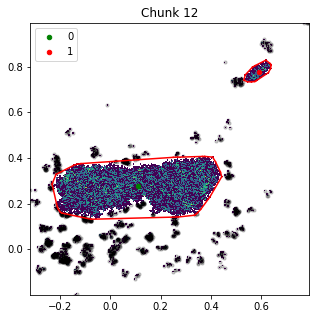

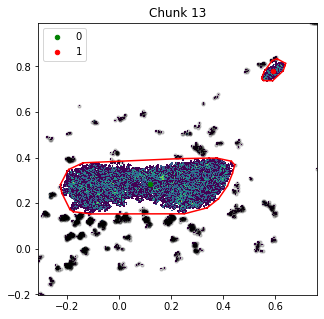

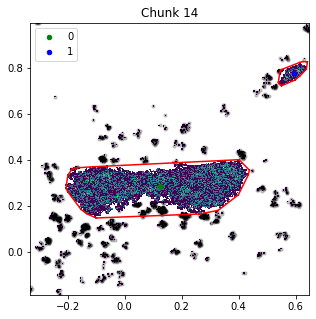

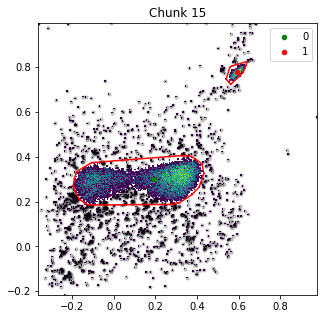

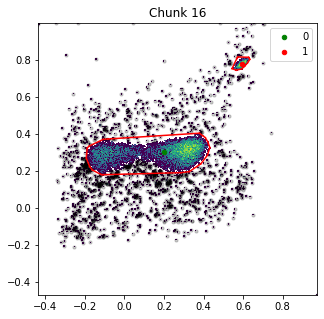

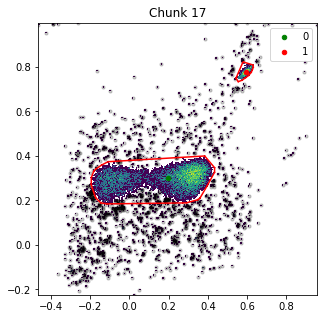

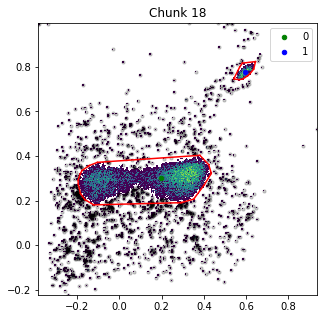

In [22]:
from immunova.flow.gating.utilities import centroid
from itertools import cycle
clustered_data = list()
for i, sample in enumerate(chunks):
    print(f'Clustering {i}...')
    model = DBSCAN(eps=0.02,
                   min_samples=100,
                   algorithm='ball_tree',
                   n_jobs=-1)
    model.fit(sample[['PanGD', 'Vd2']])
    db_labels = model.labels_
    sample['labels'] = db_labels
    clustered_data.append(sample)
    
    #Plot results
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(sample['PanGD'], sample['Vd2'], bins=500, norm=LogNorm())
    colours = cycle(['green', 'blue', 'red', 'magenta', 'cyan'])
    for label, colour in zip(sample['labels'].unique(), colours):
        d = sample[sample['labels'] == label][['PanGD', 'Vd2']].values
        if label == -1:
            ax.scatter(d[:, 0], d[:, 1], c='black', s=10, alpha=0.2)
            continue
        centroid_ = centroid(d)
        ax.scatter(x=centroid_[0], y=centroid_[1], c=colour, s=20, label=label)
        hull = ConvexHull(d)
        for s in hull.simplices:
            ax.plot(d[s, 0], d[s, 1], 'k-', c='red')
        ax.legend()
    ax.set_title(f'Chunk {i}')
    fig.show()

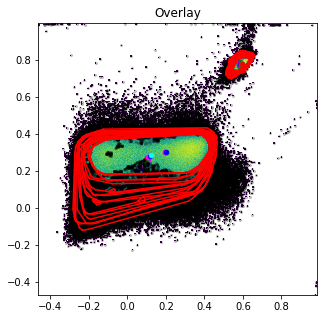

In [23]:
#Plot results
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(test['PanGD'], test['Vd2'], bins=500, norm=LogNorm())
for sample in clustered_data:
    for label, colour in zip(sample['labels'].unique(), colours):
        d = sample[sample['labels'] == label][['PanGD', 'Vd2']].values
        if label == -1:
            ax.scatter(d[:, 0], d[:, 1], c='black', s=4, alpha=0.2)
            continue
        centroid_ = centroid(d)
        ax.scatter(x=centroid_[0], y=centroid_[1], c=colour, s=20, label=label)
        hull = ConvexHull(d)
        for s in hull.simplices:
            ax.plot(d[s, 0], d[s, 1], 'k-', c='red')
ax.set_title(f'Overlay')
fig.show()

Merge overlapping polygons

In [93]:
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import cascaded_union
from itertools import permutations
polys = list()
for sample in clustered_data:
    for label in sample['labels'].unique():
        d = sample[sample['labels'] == label][['PanGD', 'Vd2']].values
        hull = ConvexHull(d)
        ind = Polygon([(d[v, 0], d[v, 1]) for v in hull.vertices])
        polys.append(ind)

In [94]:
polys = MultiPolygon(polys)

In [89]:
largest_poly = max(polys, key=lambda a: a.area)
overlaps = list()
for p in polys:
    if p.intersection(largest_poly):
        overlaps.append(p)

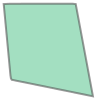

In [91]:
largest_poly

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(test['PanGD'], test['Vd2'], bins=500, norm=LogNorm())


In [79]:
cluster_centroids = list()
for i, x in enumerate(clustered_data):
    for cluster in x['labels'].unique():
        if cluster == -1:
            continue
        d = x[x['labels'] == cluster][['PanGD', 'Vd2']].values
        centroid_ = centroid(d)
        cluster_centroids.append(dict(chunk_idx=i, cluster=cluster,
                                     x=centroid_[0], y=centroid_[1]))
cluster_centroids = pd.DataFrame(cluster_centroids)

In [80]:
meta = KMeans(n_clusters=3, n_init=100, precompute_distances=True, random_state=42, n_jobs=-1)
meta.fit(cluster_centroids[['x', 'y']].values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=100, n_jobs=-1, precompute_distances=True,
       random_state=42, tol=0.0001, verbose=0)

In [81]:
cluster_centroids['meta_cluster'] = meta.labels_

In [84]:
cluster_centroids

,chunk_idx,cluster,x,y,meta_cluster
0,0,1,0.068972,0.210190,1
1,0,0,0.570294,0.776233,0
2,0,2,-0.071510,-0.021819,2
3,1,0,0.066387,0.211845,1
4,1,1,0.577781,0.773819,0
5,1,2,0.582813,0.823915,0
6,1,3,0.290220,0.049433,1
7,2,0,0.052317,0.217007,1
8,2,1,0.588426,0.784370,0
9,3,0,0.054223,0.218188,1


In [82]:
meta.cluster_centers_

array([[ 0.58818105,  0.78037927],
       [ 0.12581192,  0.2350876 ],
       [-0.10508435,  0.01444426]])

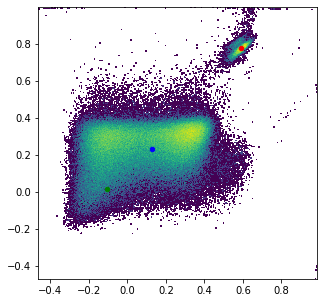

In [83]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(test['PanGD'], test['Vd2'], bins=500, norm=LogNorm())
colours = cycle(['red', 'blue', 'green', 'orange', 'yellow'])
for x, c in zip(meta.cluster_centers_, colours):
    ax.scatter(x[0], x[1], c=c, s=20)
fig.show()

In [71]:
cluster_centroids.plot()

,_id,x,y,meta_cluster
0,Chunk 0_Cluster 1,0.068972,0.210190,1
1,Chunk 0_Cluster 0,0.570294,0.776233,0
2,Chunk 0_Cluster 2,-0.071510,-0.021819,2
3,Chunk 1_Cluster 0,0.066387,0.211845,1
4,Chunk 1_Cluster 1,0.577781,0.773819,0
5,Chunk 1_Cluster 2,0.582813,0.823915,0
6,Chunk 1_Cluster 3,0.290220,0.049433,1
7,Chunk 2_Cluster 0,0.052317,0.217007,1
8,Chunk 2_Cluster 1,0.588426,0.784370,0
9,Chunk 3_Cluster 0,0.054223,0.218188,1


In [ ]:
def meta_clustering()

In [9]:
for x in samples:
    print(f'Gating {x}...')
    hc = Gating(exp, x)
    
    print('mixture model...')
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_gdt', definition='+')
    child_populations.add_population('gmm_gdtNEG', definition='-')
    pre_filter=dict(xmin=0.4, xmax=1.0, ymin=0.4, ymax=1.0)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
    hc.create_gate(gate_name='gmm_gdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_gdt',
                          performance_record=performance, save=True, plot=False)
    
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_nongdt', definition='+')
    child_populations.add_population('gmm_nongdtNEG', definition='-')
    pre_filter=dict(xmin=0, xmax=0.5, ymin=0, ymax=0.4)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
    hc.create_gate(gate_name='gmm_nongdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_nongdt',
                          performance_record=performance, save=True, plot=False)
    
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_vd2Neg', definition='+')
    child_populations.add_population('gmm_vd2NegNEG', definition='-')
    pre_filter=dict(xmin=0.5, xmax=1, ymin=0, ymax=0.4)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
    hc.create_gate(gate_name='gmm_vd2Neg', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_vd2Neg',
                          performance_record=performance, save=True, plot=False)
    
    print('dbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

    sampling_kwargs = dict()
    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, distance_nn=0.02,
                          downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='dbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='dbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dbscan_gdt',
                          performance_record=performance, save=True, plot=False)
    
    print('hdbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('hdbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('hdbscan_vd2', target=[0.6, 0.2], weight=1)

    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='hdbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='hdbscan_gdt',
                              performance_record=performance, save=True, plot=False)
    
    print('2D density threshold...')
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_gdt', definition=['++'])
    child_populations.add_population('dens2d_nongdt', definition=['--'])
    child_populations.add_population('dens2d_vd2', definition=['-+'])
    child_populations.add_population('dens2d_noise', definition=['+-'])
    gate_definition = dict(x='PanGD', y='Vd2', kde_bw=0.1, peak_threshold=0.05)
    hc.create_gate(gate_name='dens2d_gdt', parent='manual_liveCD3', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dens2d_gdt',
                          performance_record=performance, save=True, plot=False)
    hc.save(overwrite=True)
    print('Complete!')
    print('.........................................................')

Gating hc1...
mixture model...
dbscan...
Expected 3 populations, identified 2; {0, 1, -1}
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting.
hdbscan...
2D density threshold...
Saved successfully!
Complete!
.........................................................
Gating hc4...
mixture model...
dbscan...
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting.
hdbscan...
2D density threshold...
Saved successfully!
Complete!
.........................................................
Gating hc5...
mixture model...
dbscan...
Expected 3 populations, identified 2; {0, 1, -1}
Populations f['dbscan_gdt', 'dbscan_vd2'] assigned to the same cluster 1;prioritising dbscan_gdt based on weighting.
hdbscan...
Populations f['hdbscan_gdt', 'hdbscan_vd2'] assigned to the same cluster 0;prioritising hdbscan_gdt based on weighting.
2D density threshold...
Saved successfu

<h2>Evaluate performance</h2>

In [48]:
from tqdm import tqdm, tqdm_notebook
def calc_performance(so, true_pop_name, predicted_pop_name, parent):
    parent = so.get_population_df(parent)
    automated = so.get_population_df(predicted_pop_name)
    manual = so.get_population_df(true_pop_name)
    parent['auto'], parent['manual'] = 0, 0
    parent['auto'] = parent['auto'].mask(parent.index.isin(automated.index), 1)
    parent['manual'] = parent['manual'].mask(parent.index.isin(manual.index), 1)
    
    recall = recall_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    precision = precision_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    accuracy = accuracy_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    f1 = f1_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    tn, fp, fn, tp = confusion_matrix(y_pred=parent['auto'], y_true=parent['manual']).ravel()
    fpr = fp/(fp+tn)
    
    return dict(recall=recall, precision=precision, accuracy=accuracy, f1_score=f1, FPR=fpr)

gdt_performance = list()
nongdt_performance = list()
vd2_performance = list()
for x in tqdm(samples):
    hc = Gating(exp, x)
    #GMM
    results = calc_performance(hc, 'manual_gdt', 'gmm_gdt', 'manual_liveCD3')
    results['method'] = 'gmm'
    results['id'] = x
    gdt_performance.append(results)
    #DBSCAN
    results = calc_performance(hc, 'manual_gdt', 'dbscan_gdt', 'manual_liveCD3')
    results['method'] = 'dbscan'
    results['id'] = x
    gdt_performance.append(results)
    results = calc_performance(hc, 'manual_nongdt', 'dbscan_nongdt', 'manual_liveCD3')
    results['method'] = 'dbscan'
    results['id'] = x
    nongdt_performance.append(results)
    results = calc_performance(hc, 'manual_vd2Neg', 'dbscan_vd2', 'manual_liveCD3')
    results['method'] = 'dbscan'
    results['id'] = x
    vd2_performance.append(results)
    #HDBSCAN
    results = calc_performance(hc, 'manual_gdt', 'hdbscan_gdt', 'manual_liveCD3')
    results['method'] = 'hdbscan'
    results['id'] = x
    gdt_performance.append(results)
    results = calc_performance(hc, 'manual_nongdt', 'hdbscan_nongdt', 'manual_liveCD3')
    results['method'] = 'hdbscan'
    results['id'] = x
    nongdt_performance.append(results)
    results = calc_performance(hc, 'manual_vd2Neg', 'hdbscan_vd2', 'manual_liveCD3')
    results['method'] = 'hdbscan'
    results['id'] = x
    vd2_performance.append(results)
    #2D Density Threshold
    results = calc_performance(hc, 'manual_gdt', 'dens2d_gdt', 'manual_liveCD3')
    results['method'] = 'dens2d'
    results['id'] = x
    gdt_performance.append(results)
    results = calc_performance(hc, 'manual_nongdt', 'dens2d_nongdt', 'manual_liveCD3')
    results['method'] = 'dens2d'
    results['id'] = x
    nongdt_performance.append(results)
    results = calc_performance(hc, 'manual_vd2Neg', 'dens2d_vd2', 'manual_liveCD3')
    results['method'] = 'dens2d'
    results['id'] = x
    vd2_performance.append(results)
    

100%|██████████| 14/14 [01:18<00:00,  5.63s/it]


In [61]:
gdt_results = pd.DataFrame(gdt_performance)
nongdt_results = pd.DataFrame(nongdt_performance)
vd2_results = pd.DataFrame(vd2_performance)

In [62]:
import seaborn as sns

In [63]:
def rename_method(x):
    if 'gmm' in x:
        return 'Gaussian Mixture Model'
    if 'hdbscan' in x:
        return 'HDBSCAN'
    if 'dbscan' in x:
        return 'DBSCAN'
    if 'dens2d' in x:
        return 'Density threshold (2D)'
    return x
gdt_results['method'] = gdt_results['method'].apply(rename_method)
nongdt_results['method'] = nongdt_results['method'].apply(rename_method)
vd2_results['method'] = vd2_results['method'].apply(rename_method)

Text(0, 0.5, '')

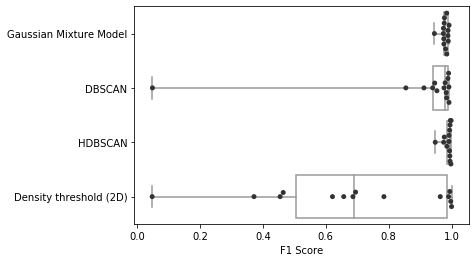

In [64]:
ax = sns.boxplot(x="f1_score", y="method", data=gdt_results, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=gdt_results, color=".2")
ax.set_xlabel('F1 Score')
ax.set_ylabel('')

Text(0, 0.5, '')

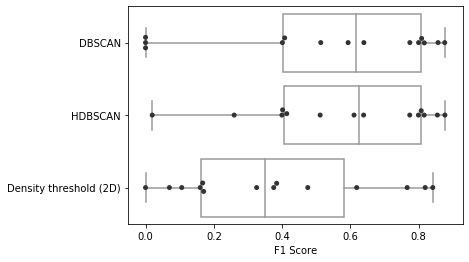

In [65]:
ax = sns.boxplot(x="f1_score", y="method", data=nongdt_results, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=nongdt_results, color=".2")
ax.set_xlabel('F1 Score')
ax.set_ylabel('')

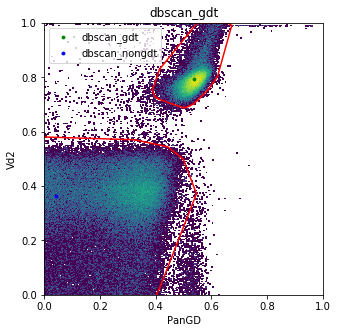

In [78]:
hc = Gating(exp, 'hc4')
hc.plotting.plot_gate('dbscan_gdt')

In [79]:
hc.populations['dbscan_gdt']

Node('/root/cells/lymphocytes/manual_liveCD3/dbscan_gdt', geom={'shape': 'cluster', 'x': 'PanGD', 'y': 'Vd2'}, index=array([     4,     15,     21, ..., 627738, 627739, 627747]), prop_of_parent=0.1987702539381235, prop_of_total=0.09274581519972983, warnings=["Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting."])

In [83]:
data = apply_transform(hc.get_population_df('dbscan_nongdt'), ['PanGD', 'Vd2'], 'logicle')
parent = apply_transform(hc.get_population_df('manual_liveCD3'), ['PanGD', 'Vd2'], 'logicle')

In [96]:
import math
d = np.ceil(parent.shape[0]/30000)
chunksize = np.ceil(parent.shape[0]/d)
int(chunksize)

29291

Text(0, 0.5, '')

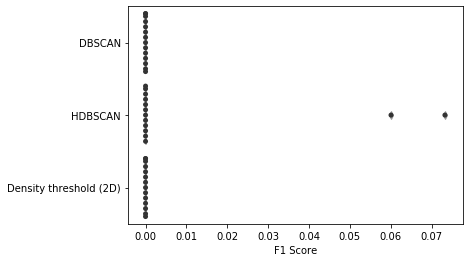

In [66]:
ax = sns.boxplot(x="f1_score", y="method", data=vd2_results, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=vd2_results, color=".2")
ax.set_xlabel('F1 Score')
ax.set_ylabel('')